In [1]:
# Import relevant modules
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.image as mpimg
import numpy
from PIL import Image
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


### DATA PREPARATION

In [ ]:
# Yuan add description of what you did in ArcGis to get pixels as png

In [3]:
def feature_to_array(file_n):
    #The input of the function is a raster file with dimentions (n pixels,m pixels), 
    #and the output is going to be an array of dimmensions (m*n,1). 
    #Each pixel is going to have a unique identifier (index in the array). 
    #This index follows the formula (i*n)+j where (i,j) is the position of the pixel in the image 
    #and n is the width of the image.
    im = mpimg.imread(file_n)  
    im_greyscale = rgb2gray(im)   
    imarray = numpy.array(im_greyscale)
    feature=[i for a in imarray for i in a]
    return feature

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def read_pictures(filename):
    file_name=filename
    im = mpimg.imread(file_name)  
    im_greyscale = rgb2gray(im)  

In [5]:
# X variables
file_name='Raster_images/BusStop.png'
bus=feature_to_array(file_name) # array1

file_name='Raster_images/Mosquito.png'
mosquito=feature_to_array(file_name) # array4

file_name='Raster_images/Str_Density.png'
street=feature_to_array(file_name) # array5

file_name='Raster_images/Trash.png'
trash=feature_to_array(file_name) # array6

# Y variable
file_name='Raster_images/Case.png'
case=feature_to_array(file_name) # array2

# In or outside Singapore
file_name='Raster_images/Land.png'
land=feature_to_array(file_name) # array3

In [6]:
#cases = list(case/np.max(case)) # Normalize
inorout = list(1-(land/np.max(land))) # get binary value indicating whether pixel is inside Singapore or not

In [7]:
Data = pd.DataFrame([bus,street,trash,mosquito,case]).T
Data.head()

In [9]:
Data_filt = Data[np.array(inorout)==1.0] # filter dataset to only pixels within Singapore
Data_filt.columns = ['BusStop','Street','Trash','Mosquito','Case']
Data_filt['Case'] = np.where(Data_filt['Case']==0,1,0) # Transform Case label into 1 (=case) or 0 (=no case)

In [15]:
Data_filt.head()

,BusStop,Street,Trash,Mosquito,Case
147867,0.941176,0.941176,0.941176,0.941176,0
150112,0.941176,0.941176,0.941176,0.941176,0
150113,0.941176,0.941176,0.941176,0.941176,0
150114,0.941176,0.941176,0.941176,0.941176,0
151167,0.219608,0.121569,0.000000,0.941176,0


In [31]:
print Data_filt.groupby('Case').size()
print (Data_filt.groupby('Case').size()/len(Data_filt))*100

Case
0    276140
1      3428
dtype: int64
Case
0    98.773822
1     1.226178
dtype: float64


#### Recorded Dengue fever cases are approximately 1.2% of the available data. For this reason, the optimal evaluation metrix needs to be applied: Instead of accuracy rate, we use AUC score.

    The AUC, which is part of performance metric of a logistic regression, is a commonly used evaluation metric for binary classification problems like predicting a Buy or Sell decision (binary decision). The interpretation is that given a random positive observation and negative observation, the AUC gives the proportion of the time you guess which is correct. It is less affected by sample balance than accuracy. A perfect model will score an AUC of 1, while random guessing will score an AUC of around 0.5, a meager 50% chance on each other. 
 
(https://www.kaggle.com/wiki/AreaUnderCurve )

### MACHINE LEARNING

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import statsmodels.formula.api as smf
#import itertools

In [17]:
X = Data_filt[['BusStop','Street','Trash','Mosquito']]
Y = Data_filt['Case']

In [20]:
X_train, X_test = train_test_split(X, test_size=0.2, random_state=21)
Y_train, Y_test = train_test_split(Y, test_size=0.2, random_state=21)

#### Logistic Regression

In [39]:
# Let's fit the logit model
# http://statsmodels.sourceforge.net/stable/generated/statsmodels.discrete.discrete_model.Logit.html?highlight=logistic
logit_mod = smf.logit('Case ~ BusStop + Street + Trash', data = Data_filt).fit()
print '\n',logit_mod.summary()

Optimization terminated successfully.
         Current function value: 0.055249
         Iterations 10

                           Logit Regression Results                           
Dep. Variable:                   Case   No. Observations:               279568
Model:                          Logit   Df Residuals:                   279564
Method:                           MLE   Df Model:                            3
Date:                Sun, 24 Apr 2016   Pseudo R-squ.:                  0.1648
Time:                        16:00:00   Log-Likelihood:                -15446.
converged:                       True   LL-Null:                       -18494.
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -6.7509      0.052   -128.826      0.000        -6.854    -6.648
BusStop        2.3141      

In [47]:
Data_filt['PredictionLogit'] = logit_mod.predict(Data_filt)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [48]:
Data_filt.head()

,BusStop,Street,Trash,Mosquito,Case,LabelLogit,PredictionLogit
147867,0.941176,0.941176,0.941176,0.941176,0,0.235177,0.235177
150112,0.941176,0.941176,0.941176,0.941176,0,0.235177,0.235177
150113,0.941176,0.941176,0.941176,0.941176,0,0.235177,0.235177
150114,0.941176,0.941176,0.941176,0.941176,0,0.235177,0.235177
151167,0.219608,0.121569,0.000000,0.941176,0,0.002505,0.002505


In [41]:
#Outuput: dictionary linking index of one dimmensional array and original i,j position of pixel:
file_name='Raster_images/Land.png'
m=numpy.array(Image.open(file_name)).shape[0]
n=numpy.array(Image.open(file_name)).shape[1]
def indexes(m,n):    
    index_2dim={}
    for M in range(0,m*n):
        index_2dim[M]={'i':int(M)/int(n), 'j':M-((int(M)/int(n))*n)}
    return index_2dim
original_index_dict=indexes(m,n)

In [57]:
# Plot the label on a map
#0 disease, 1 no disease, 0 outside singapore (since probabilty is zero anyways)
matrix = np.zeros((m,n))
for M in Data_filt.index:
    i=original_index_dict[M]['i']
    j=original_index_dict[M]['j']
    matrix[i][j]=Data_filt.PredictionLogit[M] # Get label
m_l=matrix.tolist()

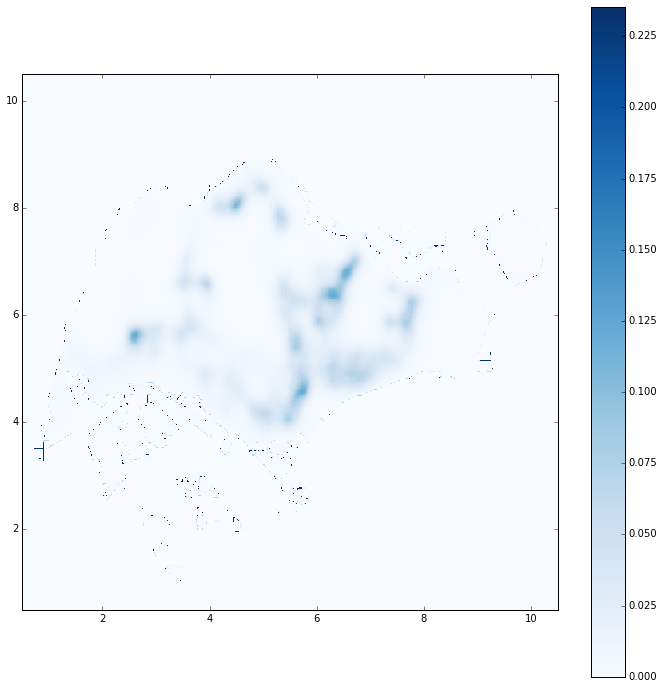

In [66]:
fig, ax = subplots(figsize=(12, 12))
plt.imshow(m_l, interpolation='nearest', cmap='Blues', extent=(0.5,10.5,0.5,10.5))
plt.colorbar()
plt.show()

##### Random Forest using Gridsearch and PCA

In [22]:
pca = PCA()
forest = RandomForestClassifier()
pipe = Pipeline(steps=[('pca', pca), ('forest', forest)])

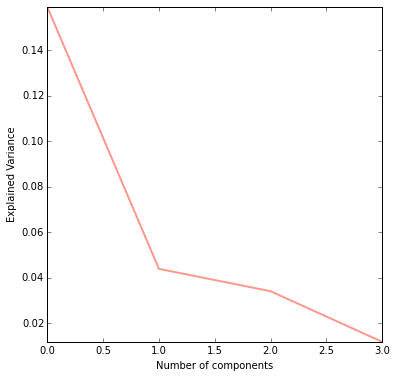

In [23]:
# Show components before running the pipeline
pca.fit(X_train.as_matrix())
plt.figure(1, figsize=(6, 6))
plt.plot(pca.explained_variance_, linewidth=2, c='salmon', alpha=0.8)
plt.axis('tight')
plt.xlabel('Number of components');
plt.ylabel('Explained Variance');

In [69]:
# Define the parameter for which the optimal value should be picked by GridsearchCV
n_components = [1,2,3]
max_features = ['auto','sqrt','log2']
criterion = ['gini','entropy']
n_estimators = [3,5,9,12,20,35] # Check some possible estimators
n_estimators = [35,40,45]

In [33]:
# Initiate the grid search
estimator = GridSearchCV(pipe,dict(pca__n_components=n_components,
                    forest__n_estimators=n_estimators, forest__criterion=criterion,
                    forest__max_features=max_features),iid=True,cv=5,refit=True,scoring='roc_auc',n_job=-1)

In [34]:
# Parameters that can be set
#estimator.get_params().keys()

In [35]:
# This takes considerable time
estimator.fit(X_train, Y_train)
print estimator.best_estimator_
print estimator.best_params_
print estimator.best_score_

Pipeline(steps=[('pca', PCA(copy=True, n_components=3, whiten=False)), ('forest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=35, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])
{'forest__max_features': 'auto', 'pca__n_components': 3, 'forest__n_estimators': 35, 'forest__criterion': 'gini'}
0.927701465502


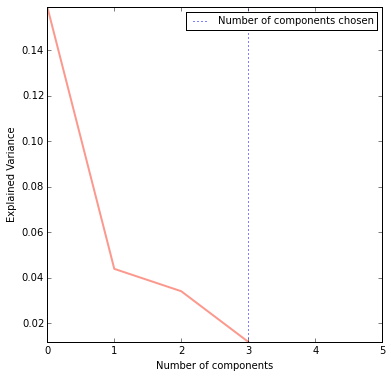

In [64]:
plt.figure(1, figsize=(6, 6))
plt.plot(pca.explained_variance_, linewidth=2, c='salmon', alpha=0.8)
plt.axis('tight')
plt.xlabel('Number of components');
plt.ylabel('Explained Variance');
plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='Number of components chosen')
plt.legend(prop=dict(size=10))
plt.xlim(0,5.0)
plt.show()

***Since the best PCA picks 3 components, we will not perform PCA in the manual approach***

##### Manual Random Forest

In [68]:
def get_results(n_components,max_features,criterion,n_estimators,X,Y):
    kf = KFold(n=len(X), n_folds=12, shuffle=True, random_state=21)
    d = []
    for train_index, test_index in kf:
        for rf_features,criter,rf_estimators in itertools.product(max_features,criterion,n_estimators):
            X_tr, X_test = X[train_index], X[test_index]
            X_train, X_validation = train_test_split(X_tr, test_size=0.2, random_state=21)
            Y_tr, Y_test = Y[train_index], Y[test_index]
            Y_train, Y_validation = train_test_split(Y_tr, test_size=0.2, random_state=21)
            del X_tr
            del Y_tr
            forest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion=criter,
                    max_depth=None, max_features=rf_features, max_leaf_nodes=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=rf_estimators, n_jobs=1,
                    oob_score=False, random_state=21, verbose=0,
                    warm_start=False)
            forest.fit(X_train,Y_train)
            forest_pred = forest.predict(X_validation)
            name = '%s,%s,%s'%(str(rf_features),str(criter),str(rf_estimators))
            d.append((name,roc_auc_score(Y_validation,forest_pred),X_train,X_test,Y_train,Y_test))
    return sorted(d, key=lambda tup: tup[1])[-1]

In [70]:
# Get the best parameters
best = get_results(n_components,max_features,criterion,n_estimators,X.as_matrix(),Y.as_matrix())
best_params,X_train_best,X_test_best,Y_train_best,Y_test_best = best[0].split(','),best[2],best[3],best[4],best[5]

# Run RF
forest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion=best_params[1],
                max_depth=None, max_features=best_params[0], max_leaf_nodes=None,
                min_samples_leaf=1, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=int(best_params[2]), n_jobs=1,
                oob_score=False, random_state=21, verbose=0,
                warm_start=False)
forest.fit(X_train_best,Y_train_best)
Data_filt['LabelsRF'] = forest.predict(X)

# Get results
print accuracy_score(Y_test_best,forest.predict(X_test_best))
print roc_auc_score(Y_test_best,forest.predict(X_test_best))

0.991286431729
0.763164578136


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


NameError: name 'pred_labels' is not defined

In [71]:
print confusion_matrix(Y, Data_filt['LabelsRF'])

[[275439    701]
 [  1122   2306]]


In [ ]:
# http://blog.datadive.net/selecting-good-features-part-iii-random-forests/

In [72]:
Data_filt.head()

,BusStop,Street,Trash,Mosquito,Case,LabelLogit,PredictionLogit,LabelsRF
147867,0.941176,0.941176,0.941176,0.941176,0,0.235177,0.235177,0
150112,0.941176,0.941176,0.941176,0.941176,0,0.235177,0.235177,0
150113,0.941176,0.941176,0.941176,0.941176,0,0.235177,0.235177,0
150114,0.941176,0.941176,0.941176,0.941176,0,0.235177,0.235177,0
151167,0.219608,0.121569,0.000000,0.941176,0,0.002505,0.002505,0


In [78]:
Data_filt.LabelsRF.value_counts()

0    276561
1      3007
Name: LabelsRF, dtype: int64

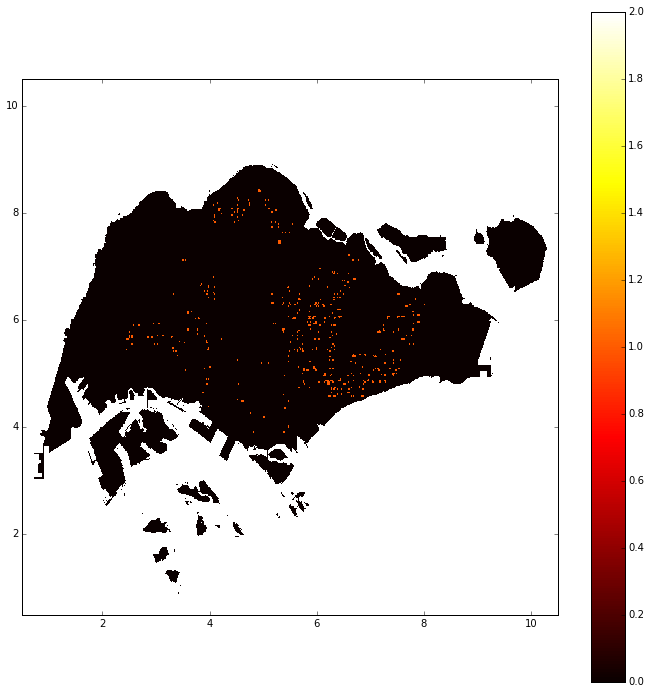

In [83]:
#0 disease, 1 no disease, 2 outside singapore 
matrix = np.zeros((m,n))+2
for M in Data_filt.index:
    i=original_index_dict[M]['i']
    j=original_index_dict[M]['j']
    matrix[i][j]=Data_filt.LabelsRF[M]
m_l=matrix.tolist()
fig, ax = subplots(figsize=(12, 12))
plt.imshow(m_l, interpolation='nearest', cmap='hot', extent=(0.5,10.5,0.5,10.5))
plt.colorbar()
plt.show()